# Derive models of spacecraft with star tracker

Do all imports.

In [3]:
import sympy as sym
import numpy as np
from IPython.display import display, Markdown
import ae353_spacecraft_design as design

# Suppress the use of scientific notation when printing small numbers
np.set_printoptions(suppress=True)

## Create spacecraft

Create a visualizer to help with placement of reaction wheels.

In [4]:
# Create the visualizer
vis = design.create_visualizer()

# Show the visualizer in this notebook
vis.jupyter_cell()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7009/static/


Specify the location of four reaction wheels in terms of their right ascension $\alpha$ and declination $\delta$. You cannot change the number of wheels, but it is likely that you **must** change the location of wheels in order for the system to be controllable.

In [5]:
wheels = [
    {'alpha': 1 * np.pi / 4, 'delta': 0.},
    {'alpha': 3 * np.pi / 4, 'delta': 0.},
    {'alpha': 5 * np.pi / 4, 'delta': 0.},
    {'alpha': 7 * np.pi / 4, 'delta': 0.},
]

Show wheels in the visualizer. You will be warned if any wheel obscures the star tracker (i.e., the "scope") or if any two wheels are too close together.

In [6]:
design.show_wheels(vis, wheels)

Create a model of the spacecraft in URDF format. This will **overwrite** the file `spacecraft.urdf` in the `urdf` directory. Also, compute the mass $m$ and inertia matrix $J$ of the spacecraft (including all the wheels). These parameters will be used later when deriving equations of motion.

In [7]:
m, J = design.create_spacecraft(wheels)

display(Markdown(
       r'$$'
    + fr'm = {sym.latex(np.round(m, decimals=2))}'
    +  r' \qquad\qquad '
    + fr'J = {sym.latex(sym.Matrix(J.round(decimals=2)))}'
    +  r'$$'
))

$$m = 19.0 \qquad\qquad J = \left[\begin{matrix}18.88 & 0.0 & 0.0\\0.0 & 18.88 & 0.0\\0.0 & 0.0 & 28.44\end{matrix}\right]$$

## Create stars

Specify the location of at most ten stars in terms of their right ascension $\alpha$ and declination $\delta$. It is likely that you **must** change the number and/or location of stars in order for the system to be observable.

In [8]:
stars = [
    {'alpha':  0.00, 'delta':  0.00}, # <-- To add a star, append a copy of this dict to the list. To change
                                      #     the location of a star, change the value of alpha and delta
]

Show where the stars will appear in the scope. The plot on the left shows $\alpha$ and $\delta$ gridelines. The plot on the right shows $y_\text{star}$ and $z_\text{star}$ gridlines.

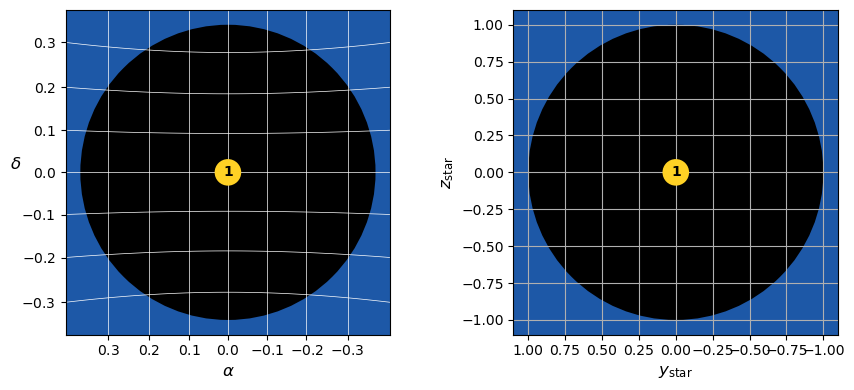

In [9]:
design.show_stars(stars)

Create a file with the location of stars. This will **overwrite** the file `stars.json` in the `urdf` directory.

In [10]:
design.create_stars(stars)

## Create dynamic model

Derive the equations of motion.

In [11]:
# Define yaw, pitch, roll angles
psi, theta, phi = sym.symbols('psi, theta, phi')

# Define angular velocities
w_x, w_y, w_z = sym.symbols('w_x, w_y, w_z')

# Define torques
tau_1, tau_2, tau_3, tau_4 = sym.symbols('tau_1, tau_2, tau_3, tau_4')

# Compute resultant torques
T1 = - tau_1 * sym.Matrix(wheels[0]['xyz']) / np.linalg.norm(wheels[0]['xyz'])
T2 = - tau_2 * sym.Matrix(wheels[1]['xyz']) / np.linalg.norm(wheels[1]['xyz'])
T3 = - tau_3 * sym.Matrix(wheels[2]['xyz']) / np.linalg.norm(wheels[2]['xyz'])
T4 = - tau_4 * sym.Matrix(wheels[3]['xyz']) / np.linalg.norm(wheels[3]['xyz'])
T = sym.nsimplify(T1 + T2 + T3 + T4)

# Define rotation matrices
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0], [sym.sin(psi), sym.cos(psi), 0], [0, 0, 1]])
Ry = sym.Matrix([[sym.cos(theta), 0, sym.sin(theta)], [0, 1, 0], [-sym.sin(theta), 0, sym.cos(theta)]])
Rx = sym.Matrix([[1, 0, 0], [0, sym.cos(phi), -sym.sin(phi)], [0, sym.sin(phi), sym.cos(phi)]])

# Define the transformation from angular velocity to angular rates
ex = sym.Matrix([[1], [0], [0]])
ey = sym.Matrix([[0], [1], [0]])
ez = sym.Matrix([[0], [0], [1]])
M = sym.simplify(sym.Matrix.hstack((Ry @ Rx).T @ ez, Rx.T @ ey, ex).inv(), full=True)

# Define euler's equations
Jx, Jy, Jz = [sym.nsimplify(j) for j in np.diag(J)]
euler = sym.Matrix([[(1 / Jx) * (T[0] + (Jy - Jz) * w_y * w_z)],
                    [(1 / Jy) * (T[1] + (Jz - Jx) * w_z * w_x)],
                    [(1 / Jz) * (T[2] + (Jx - Jy) * w_x * w_y)]])

# Define equations of motion
f = sym.simplify(sym.Matrix.vstack(M * sym.Matrix([[w_x], [w_y], [w_z]]), euler), full=True)

The equations of motion have this form:

$$\begin{bmatrix} \dot{\psi} \\ \dot{\theta} \\ \dot{\phi} \\ \dot{w_x} \\ \dot{w_y} \\ \dot{w_z} \end{bmatrix} = f\left(\psi, \theta, \phi, w_x, w_y, w_z, \tau_1, \tau_2, \tau_3, \tau_4\right).$$

Here is the function $f$:

In [12]:
f

Matrix([
[                                                                                                                                                      (w_y*sin(phi) + w_z*cos(phi))/cos(theta)],
[                                                                                                                                                                   w_y*cos(phi) - w_z*sin(phi)],
[                                                                                                                                       w_x + w_y*sin(phi)*tan(theta) + w_z*cos(phi)*tan(theta)],
[-58925565098879*tau_1/1573472222500000 + 58925565098879*tau_2/1573472222500000 + 58925565098879*tau_3/1573472222500000 - 707106781186547*tau_4/18881666670000000 - 318722222*w_y*w_z/629388889],
[  -58925565098879*tau_1/1573472222500000 - 58925565098879*tau_2/1573472222500000 + 58925565098879*tau_3/1573472222500000 + 58925565098879*tau_4/1573472222500000 + 318722222*w_x*w_z/629388889],
[                    

## Create sensor model

Create symbolic variables for right ascension $\alpha$ and declination $\delta$ of each star.

In [13]:
alpha, delta = sym.symbols('alpha, delta')

Derive the sensor model for one star.

In [14]:
# Position of star in space frame
p_star_in_space = sym.Matrix([[sym.cos(alpha) * sym.cos(delta)],
                              [sym.sin(alpha) * sym.cos(delta)],
                              [sym.sin(delta)]])

# Orientation of body frame in space frame
R_body_in_space = Rz * Ry * Rx

# Position of star in body frame (assuming origin of body and space frames are the same)
p_star_in_body = R_body_in_space.T * p_star_in_space

# Position of star in image frame
r = sym.nsimplify(design.scope_radius)
p_star_in_image = (1 / r) * sym.Matrix([[p_star_in_body[1] / p_star_in_body[0]],
                                        [p_star_in_body[2] / p_star_in_body[0]]])

# Sensor model for each star
g = sym.simplify(p_star_in_image, full=True)

The sensor model has the following form:

$$\begin{bmatrix} y_\text{star} \\ z_\text{star} \end{bmatrix} = g(\psi, \theta, \phi, \alpha, \delta).$$

Here is the function $g$:

In [15]:
g

Matrix([
[21*(sin(delta)*sin(phi)*cos(theta) + sin(phi)*sin(theta)*cos(delta)*cos(alpha - psi) + sin(alpha - psi)*cos(delta)*cos(phi))/(8*(-sin(delta)*sin(theta) + cos(delta)*cos(theta)*cos(alpha - psi)))],
[21*(sin(delta)*cos(phi)*cos(theta) - sin(phi)*sin(alpha - psi)*cos(delta) + sin(theta)*cos(delta)*cos(phi)*cos(alpha - psi))/(8*(-sin(delta)*sin(theta) + cos(delta)*cos(theta)*cos(alpha - psi)))]])

Again, this sensor model is for **one star only**. You will have to use a copy of this same model for each star you defined in the "Create Stars" section of this notebook.

# Spacecraft with reaction wheels and star tracker

Import modules and configure the notebook.

In [16]:
# Standard modules
import time
import numpy as np
import matplotlib.pyplot as plt

# My own script (an interface to the simulator)
import ae353_spacecraft_simulate

Create an instance of the `Simulator` class, which is an interface to the [pybullet](http://pybullet.org) simulation engine.

Here are two rules of thumb about the `display` argument:
* When doing development, turn the display on (`display=True`).
* When collecting data or saving a video, turn the display off (`display=False`).

If you are having trouble with the in-browser display — e.g., if it is running slowly on your laptop — then you can try the pybullet display instead (`display=False` and `display_pybullet=True`).

The `seed` argument (an integer, default `None`) initializes the random number generator that is used by the simulator.

In [17]:
simulator = ae353_spacecraft_simulate.Simulator(
    display=True,
    seed=None,
)

argv[0]=
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7010/static/


Choose a camera view from the following options:

* `camera_sideview()`
* `camera_scopeview()`
* `camera_catview()`

In [18]:
simulator.camera_sideview()

Define a controller that maps sensor measurements to actuator commands. By default, it applies zero torque to each reaction wheel. Modify the `run` function to make the controller behave differently. This function will be called 25 times per second (i.e., at 25 Hz) by the simulator.

In [41]:
class Controller:
    def __init__(self):
        # FIXME: add class variable names to this list (e.g., 'xhat')
        # if you want these variables to be logged by the simulator
        self.variables_to_log = ['xhat']
    
    def reset(self):
        self.xhat = np.zeros(6)
    
    def run(self, t, star_measurements):
        """
        The variable t is the current time.

        The variable star_measurements is a 1d array of length twice the
        number N of stars:

            [y_1, z_1, y_2, z_2, ..., y_N, z_N]
        
        The image coordinates y_i and z_i of the i'th star (for i = 1, ..., N)
        are at index 2 * i - 2 and 2 * i - 1 of this array, respectively.
        """
        
        # FIXME: replace the following lines
        torque_1 = 0.
        torque_2 = 0.
        torque_3 = 0.
        torque_4 = 0.
        
        return torque_1, torque_2, torque_3, torque_4

Create an instance of the controller.

In [42]:
controller = Controller()

You could reset the simulator with given initial conditions.

In [33]:
simulator.reset(
    initial_conditions={
        'psi': 0.,
        'theta': 0.,
        'phi': 0.,
        'w_x': 0.,
        'w_y': 0.,
        'w_z': 0.,
    },
    scope_noise=0.1,        # <-- standard deviation of each image coordinate of each star tracker measurement
    space_debris=True,      # <-- whether or not there is space debris
    docking_time=60.        # <-- how long it takes for the space-cat to dock with the spacecraft
)

Or, you could reset the simulator with initial conditions sampled at random (in particular, each initial condition will be sampled from a normal distribution that has mean $\mu=0.0$ and standard deviation $\sigma = 0.1$).

In [43]:
simulator.reset(
    initial_conditions=None,
    scope_noise=0.1,        # <-- standard deviation of each image coordinate of each star tracker measurement
    space_debris=True,      # <-- whether or not there is space debris
    docking_time=60.        # <-- how long it takes for the space-cat to dock with the spacecraft
)

Reset the controller.

In [44]:
controller.reset()

Run the simulator. It will quit when one of the following conditions is satisfied:

* Any star goes out of view of the scope.
* Any reaction wheel has angular velocity exceeding +/- 50 rad/s.
* The maximum time is reached.

If you create a video (i.e., if `video_filename` is not `None`), then — by default — the size of that video will be 640x480 pixels. You can change the size of the video by calling the following function **before** you call `simulator.run`:

```python
simulator.set_snapshot_size(
    320, # <-- width (example)
    240, # <-- height (example)
)
```

Both the width and height must be multiples of 16. One reason why you might want to change the size is to reduce the time it takes to create a video — a smaller size will take less time (but will be lower resolution). Another reason why you might want to change the size is to get a different aspect ratio — a square video, in particular, might be more appropriate if you wanted to use `camera_scopeview`, since the image captured by the star tracker is square.

In [45]:
data = simulator.run(
    controller,           # <-- required (an instance of your Controller class)
    max_time=5.0,         # <-- optional (how long you want to run the simulation in seconds)
    data_filename=None,   # <-- optional (name of file to which you want data saved, e.g., 'my_data.json')
    video_filename=None,  # <-- optional (name of file to which you want video saved, e.g., 'my_video.mov')
    print_debug=False,    # <-- optional (whether to print debug text - this is recommended when saving video)
)

In [46]:
data.keys()

dict_keys(['t', 'psi', 'theta', 'phi', 'w_x', 'w_y', 'w_z', 'torque_1', 'torque_2', 'torque_3', 'torque_4', 'torque_1_command', 'torque_2_command', 'torque_3_command', 'torque_4_command', 'wheel_1_velocity', 'wheel_2_velocity', 'wheel_3_velocity', 'wheel_4_velocity', 'star_meas', 'xhat'])

In [47]:
t = data['t']
psi = data['psi']
psi_e = 0.
x1 = psi - psi_e

In [51]:
print(x1.shape)

(126,)


In [50]:
print(data['xhat'].shape)

(126, 6)


In [52]:
xhat1 = data['xhat'][:, 0]

In [53]:
print(xhat1.shape)

(126,)


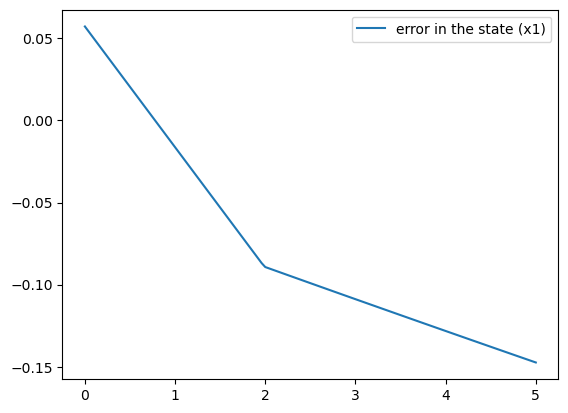

In [55]:
plt.plot(t, x1, label='error in the state (x1)')
plt.legend()

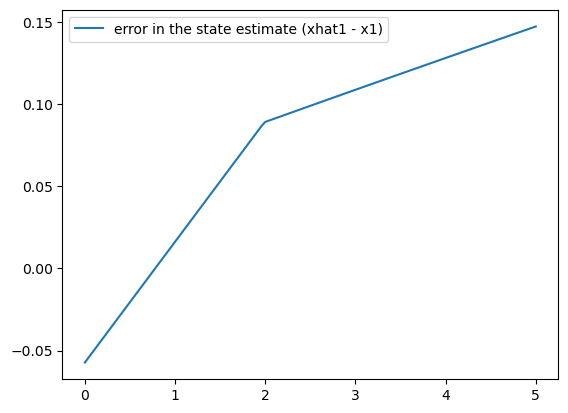

In [56]:
plt.plot(t, xhat1 - x1, label='error in the state estimate (xhat1 - x1)')
plt.legend()

Check if the space-cat has docked.

In [25]:
has_docked = simulator.has_docked()
if has_docked:
    print('The space-cat docked.')
else:
    print('The space-cat did not dock.')

The space-cat did not dock.


Get, show, and save a snapshot of the simulation after the last time step.

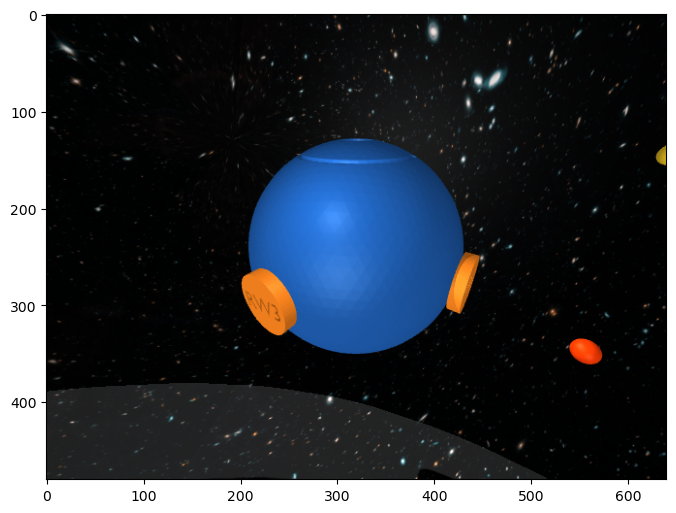

In [26]:
# Set the width and height of the snapshot (must be multiples of 16)
simulator.set_snapshot_size(
    640, # <-- width
    480, # <-- height
)

# Get snapshot as height x width x 4 numpy array of RGBA values
rgba = simulator.snapshot()

# Display snapshot
plt.figure(figsize=(8, 8))
plt.imshow(rgba)

# Save snapshot
plt.imsave('my_snapshot.png', rgba)

Get, show, and save a snapshot of the simulation from a side view, with a picture-in-picture view from the scope.

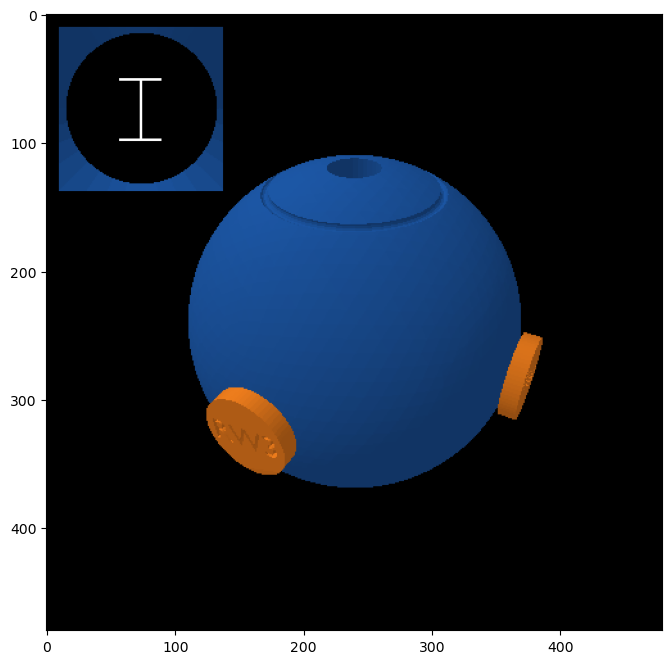

In [27]:
# Get snapshot as height x width x 4 numpy array of RGBA values
# with a picture-in-picture view of the scope
rgba = simulator.pybullet_snapshot()

# Display snapshot
plt.figure(figsize=(8, 8))
plt.imshow(rgba)

# Save snapshot
plt.imsave('my_snapshot.png', rgba)

Plot the results. (This code is meant only for development. You will want to create different and better plots for your own report.)

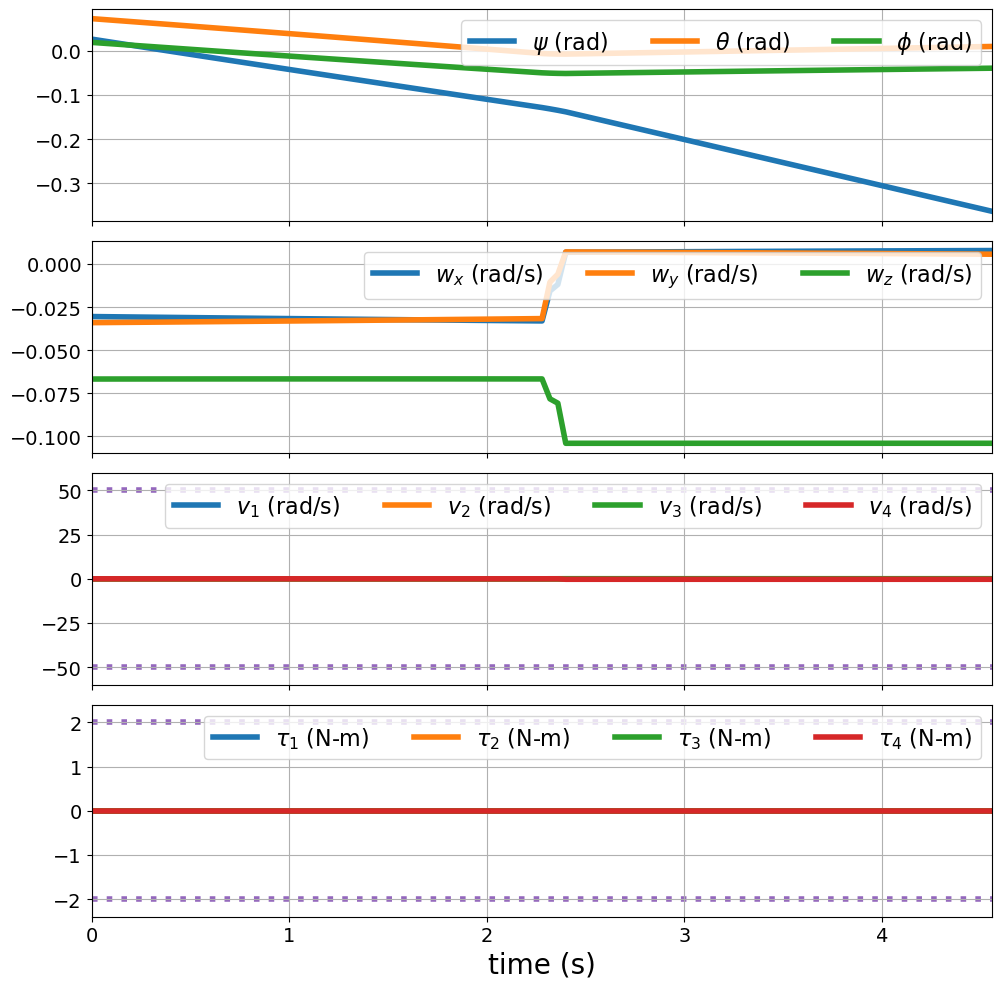

In [28]:
# Create a figure with three subplots, all of which share the same x-axis
fig, (ax_ori, ax_vel, ax_rwvel, ax_rwtau) = plt.subplots(4, 1, figsize=(10, 10), sharex=True)

# Plot yaw, pitch, roll angles
ax_ori.plot(data['t'], data['psi'], label=r'$\psi$ (rad)', linewidth=4)
ax_ori.plot(data['t'], data['theta'], label=r'$\theta$ (rad)', linewidth=4)
ax_ori.plot(data['t'], data['phi'], label=r'$\phi$ (rad)', linewidth=4)
ax_ori.grid()
ax_ori.legend(fontsize=16, ncol=3, loc='upper right')
ax_ori.tick_params(labelsize=14)

# Plot x, y, z components of angular velocity
ax_vel.plot(data['t'], data['w_x'], label=r'$w_x$ (rad/s)', linewidth=4)
ax_vel.plot(data['t'], data['w_y'], label=r'$w_y$ (rad/s)', linewidth=4)
ax_vel.plot(data['t'], data['w_z'], label=r'$w_z$ (rad/s)', linewidth=4)
ax_vel.grid()
ax_vel.legend(fontsize=16, ncol=3, loc='upper right')
ax_vel.tick_params(labelsize=14)

# Plot angular velocity of each reaction wheel
ax_rwvel.plot(data['t'], data['wheel_1_velocity'], label=r'$v_1$ (rad/s)', linewidth=4)
ax_rwvel.plot(data['t'], data['wheel_2_velocity'], label=r'$v_2$ (rad/s)', linewidth=4)
ax_rwvel.plot(data['t'], data['wheel_3_velocity'], label=r'$v_3$ (rad/s)', linewidth=4)
ax_rwvel.plot(data['t'], data['wheel_4_velocity'], label=r'$v_4$ (rad/s)', linewidth=4)
ax_rwvel.plot(
    data['t'], np.ones_like(data['t']) * simulator.v_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_rwvel.plot(
    data['t'], -np.ones_like(data['t']) * simulator.v_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_rwvel.grid()
ax_rwvel.legend(fontsize=16, ncol=4, loc='upper right')
ax_rwvel.tick_params(labelsize=14)
ax_rwvel.set_ylim(-1.2 * simulator.v_max, 1.2 * simulator.v_max)

# Plot torque applied to each reaction wheel
ax_rwtau.plot(data['t'], data['torque_1'], label=r'$\tau_1$ (N-m)', linewidth=4)
ax_rwtau.plot(data['t'], data['torque_2'], label=r'$\tau_2$ (N-m)', linewidth=4)
ax_rwtau.plot(data['t'], data['torque_3'], label=r'$\tau_3$ (N-m)', linewidth=4)
ax_rwtau.plot(data['t'], data['torque_4'], label=r'$\tau_4$ (N-m)', linewidth=4)
ax_rwtau.plot(
    data['t'], np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_rwtau.plot(
    data['t'], -np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_rwtau.grid()
ax_rwtau.legend(fontsize=16, ncol=4, loc='upper right')
ax_rwtau.tick_params(labelsize=14)


# Set x-axis properties (only need to do this on the last
# subplot since all subplots share the same x-axis)
ax_rwtau.set_xlabel('time (s)', fontsize=20)
ax_rwtau.set_xlim([data['t'][0], data['t'][-1]])
ax_rwtau.set_ylim(-1.2 * simulator.tau_max, 1.2 * simulator.tau_max)

# Make the arrangement of subplots look nice
fig.tight_layout()

Save the figure (without transparent background).

In [29]:
fig.savefig('my_figure.png', facecolor='white', transparent=False)

Plot star positions in image. This is not necessarily a useful thing to plot. The point is to show how to access measurements of star position from logged data.

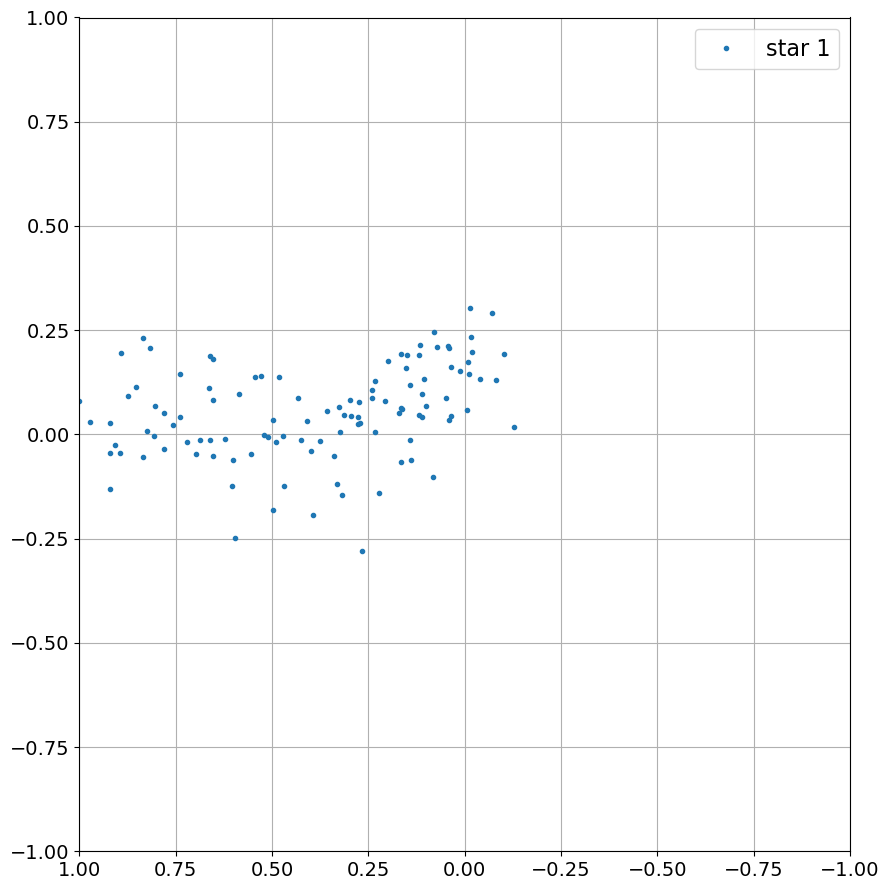

In [30]:
# Create a figure with one subplots
fig, ax = plt.subplots(1, 1, figsize=(9, 9))

# Scatter-plot the position of all stars at all time steps in the scope
for i in range(len(simulator.stars)):
    y = data['star_meas'][:, 2 * i]
    z = data['star_meas'][:, 2 * i + 1]
    ax.plot(y, z, label=f'star {i + 1}', linestyle='none', marker='.', markersize=6)

# Change appearance of axes
ax.grid()
ax.legend(fontsize=16)
ax.tick_params(labelsize=14)
ax.set_xlim(1., -1.) # <-- the "y_star" axis points left (not right)
ax.set_ylim(-1., 1.) # <-- the "z_star" axis points up

# Make the arrangement of subplots look nice
fig.tight_layout()